In [1]:
!pip install scikit-learn

In [2]:
!pip install pandas openpyxl

In [3]:
#Definir las librerias para el transcurso del proyecto
import numpy as np #Manejo de arrays
import matplotlib.pyplot as plt #Visualización de resultados 
import os #Directorios y cargar datasets
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay, f1_score
from PIL import Image #Abrir, convertir y transformar imagenes.
from sklearn.preprocessing import LabelEncoder #Etiquetas de texto a valores numericos.
import random
import pandas as pd

In [4]:
def load_data(data_dir):
    X = []
    y = []
    
    # Mapeo de clases según el número inicial del archivo
    class_map = {
        '1': 'jeff',
        '2': 'psylocke',
        '3': 'winter soldier',
        '4': 'hulk'
    }
    
    for file_name in os.listdir(data_dir):
        if file_name.endswith('.png') or file_name.endswith('.jpg'):
            file_path = os.path.join(data_dir, file_name)
            image = Image.open(file_path).convert('L')  # escala de grises
            image = image.resize((64, 64))             # redimensionar
            image = np.array(image).flatten()          # aplanar
            X.append(image)
            
            # Extraer el número antes del primer punto (ej. "1.1.png" → "1")
            class_id = file_name.split('.')[0]  # "1.1"
            class_id = class_id.split('.')[0]   # "1"
            
            if class_id in class_map:
                y.append(class_map[class_id])
            else:
                print(f"⚠️ Clase no reconocida en archivo: {file_name}")
    
    return np.array(X), np.array(y)


In [5]:
#Cargamos los datasets
data_dir = 'imgs/Personajes'
X, y = load_data(data_dir)

In [6]:
# Codificar etiquetas
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# División train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [7]:
# Normalization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
# PCA
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [9]:
# Entrenar SVM
svm = SVC(kernel='linear', random_state=42)
svm.fit(X_train_pca, y_train)

,C,1.0
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [10]:
# Predicciones y evaluación
y_pred = svm.predict(X_test_pca)
num_correctas = (y_pred == y_test).sum()
fscore = f1_score(y_test, y_pred, average='macro')

print("Número de clasificaciones correctas:", num_correctas)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F-score:", fscore)
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Número de clasificaciones correctas: 6
Accuracy: 1.0
F-score: 1.0
Classification Report:
                 precision    recall  f1-score   support

          hulk       1.00      1.00      1.00         2
          jeff       1.00      1.00      1.00         1
      psylocke       1.00      1.00      1.00         2
winter soldier       1.00      1.00      1.00         1

      accuracy                           1.00         6
     macro avg       1.00      1.00      1.00         6
  weighted avg       1.00      1.00      1.00         6



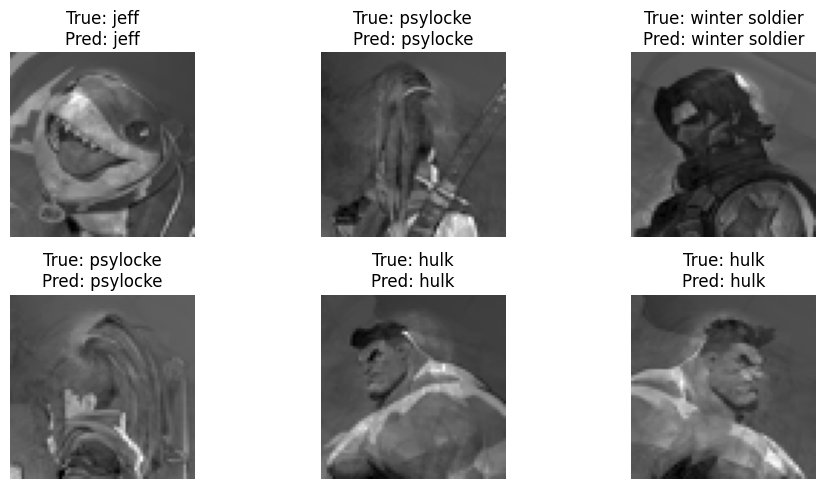

In [11]:
# Visualización de algunas predicciones
fig, axes = plt.subplots(2, 3, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    image = X_test[i].reshape(64, 64)
    ax.imshow(image, cmap='gray')
    true_label = label_encoder.inverse_transform([y_test[i]])[0]
    pred_label = label_encoder.inverse_transform([y_pred[i]])[0]
    ax.set_title(f"True: {true_label}\nPred: {pred_label}")
    ax.axis('off')
plt.tight_layout()
plt.show()

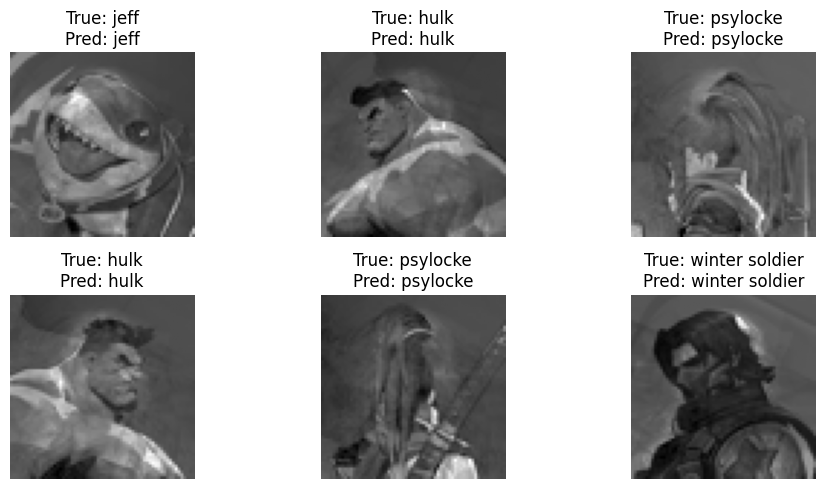

In [12]:
# Visualización aleatoria
fig, axes = plt.subplots(2, 3, figsize=(10, 5))
indices = random.sample(range(len(X_test)), 6)
for i, ax in zip(indices, axes.flat):
    image = X_test[i].reshape(64, 64)
    ax.imshow(image, cmap='gray')
    true_label = label_encoder.inverse_transform([y_test[i]])[0]
    pred_label = label_encoder.inverse_transform([y_pred[i]])[0]
    ax.set_title(f"True: {true_label}\nPred: {pred_label}")
    ax.axis('off')
plt.tight_layout()
plt.show()

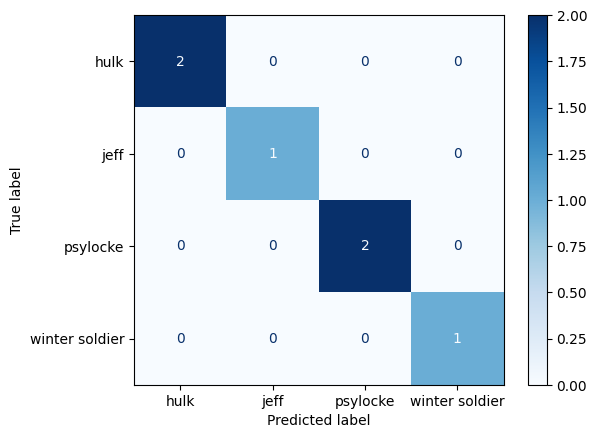

In [13]:
# Matriz de confusión
ConfusionMatrixDisplay.from_estimator(
    svm,
    X_test_pca,
    y_test,
    display_labels=label_encoder.classes_,
    cmap="Blues"
)
plt.show()

In [17]:
# Predicciones para las imagenes de Prueba
# Función para cargar imágenes
def load_test_data(data_dir):
    X = []
    y = []

    # Mapeo de clases basado en nombre de archivo
    class_map = {
        "hulk": "hulk",
        "psylocke": "psylocke",
        "winter": "winter soldier",
        "jeff": "jeff"
    }

    for file_name in os.listdir(data_dir):
        file_path = os.path.join(data_dir, file_name)
        image = Image.open(file_path).convert('L').resize((64, 64))
        image = np.array(image).flatten()
        X.append(image)

        # Detectar clase por nombre
        matched = False
        for keyword, label in class_map.items():
            if keyword in file_name.lower():
                y.append(label)
                matched = True
                break
        if not matched:
            print(f"⚠️ Clase no reconocida en archivo: {file_name}")
            y.append("desconocido")  # opcional: para evitar errores

    return np.array(X), np.array(y)

# Cargar imágenes de prueba
X_prueba, y_prueba = load_test_data("imgs/Prueba2")

# Filtrar imágenes con clase válida
valid_indices = [i for i, label in enumerate(y_prueba) if label != "desconocido"]
X_prueba = X_prueba[valid_indices]
y_prueba = [y_prueba[i] for i in valid_indices]

# Codificar etiquetas
y_prueba_encoded = label_encoder.transform(y_prueba)

# Transformar con scaler y PCA ya entrenados
X_prueba_scaled = scaler.transform(X_prueba)
X_prueba_pca = pca.transform(X_prueba_scaled)

# Predicción
y_prueba_pred = svm.predict(X_prueba_pca)

# Evaluación
accuracy_prueba = accuracy_score(y_prueba_encoded, y_prueba_pred)
num_correctas = (y_prueba_pred == y_prueba_encoded).sum()
fscore_macro = f1_score(y_prueba_encoded, y_prueba_pred, average='macro')

print("Evaluación con imágenes de Prueba")
print("Accuracy:", accuracy_prueba)
print("Número de clasificaciones correctas:", num_correctas)
print("F-score:", fscore_macro)
print("Classification Report:\n", classification_report(y_prueba_encoded, y_prueba_pred, target_names=label_encoder.classes_))

Evaluación con imágenes de Prueba
Accuracy: 0.375
Número de clasificaciones correctas: 3
F-score: 0.35
Classification Report:
                 precision    recall  f1-score   support

          hulk       0.33      0.50      0.40         2
          jeff       1.00      0.50      0.67         2
      psylocke       0.00      0.00      0.00         2
winter soldier       0.25      0.50      0.33         2

      accuracy                           0.38         8
     macro avg       0.40      0.38      0.35         8
  weighted avg       0.40      0.38      0.35         8



C:\Users\Katt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Katt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Katt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classif

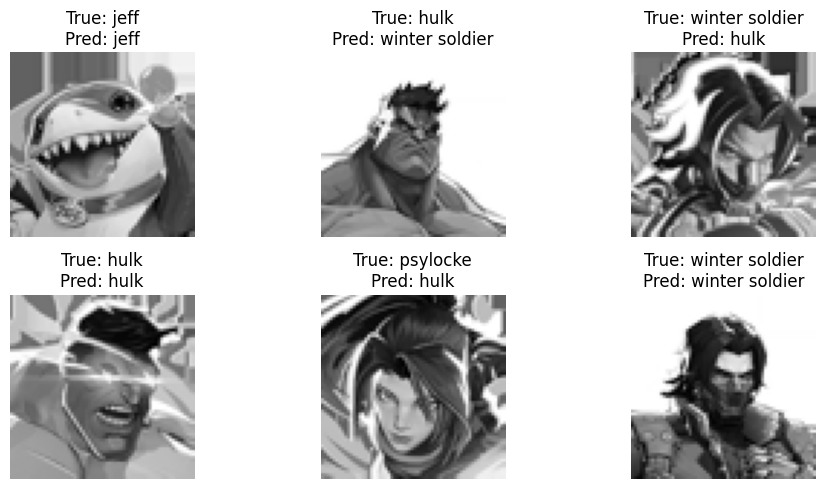

In [18]:
# Visualización aleatoria
fig, axes = plt.subplots(2, 3, figsize=(10, 5))
indices = random.sample(range(len(X_prueba)), min(6, len(X_prueba)))
for i, ax in zip(indices, axes.flat):
    image = X_prueba[i].reshape(64, 64)
    ax.imshow(image, cmap='gray')
    true_label = y_prueba[i]
    pred_label = label_encoder.inverse_transform([y_prueba_pred[i]])[0]
    ax.set_title(f"True: {true_label}\nPred: {pred_label}")
    ax.axis('off')
plt.tight_layout()
plt.show()

In [19]:
# Guardar resultados en Excel
resultados_prueba = pd.DataFrame({
    "Real": y_prueba,
    "Predicción": label_encoder.inverse_transform(y_prueba_pred)
})
resultados_prueba.to_excel("resultados_personajes.xlsx", index=False)
df_prueba = pd.read_excel("resultados_personajes.xlsx")
print(df_prueba.head())

       Real      Predicción
0      hulk  winter soldier
1      hulk            hulk
2      jeff  winter soldier
3      jeff            jeff
4  psylocke  winter soldier
